# Data Scientist Professional Practical Exam

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

# Install and Import Modules

In [1]:
# Install modules not preinstalled in DC Workspaces
!pip install dataprep
!pip install forex_python
!pip install ftfy
!pip install missingpy

  Using cached dataprep-0.4.5-py3-none-any.whl (9.9 MB)
  Using cached Metaphone-0.6-py3-none-any.whl
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached scipy-1.10.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached regex-2021.11.10-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
  Using cached varname-0.8.3-py3-none-any.whl (21 kB)
  Using cached Flask-2.2.2-py3-none-any.whl (101 kB)
  Using cached Jinja2-3.0.3-py3-none-any.whl (133 kB)
  Using cached SQLAlchemy-1.3.24-cp38-cp38-manylinux2010_x86_64.whl (1.3 MB)
  Using cached pandas-1.5.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached rapidfuzz-2.13.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached wordcloud-1.8.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
  Using cached ipywidgets-7.7.2-py2.py3-none-any.whl (123 kB)
 

In [2]:
# Import modules
import pandas as pd
import numpy as np
import statsmodels as sm
import datetime as dt
import chardet as ch 
import missingno as msno
import random as rnd

from geopy import geocoders
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
from scipy import stats

from forex_python.converter import CurrencyRates
from ftfy import fix_and_explain, fix_text
from dataprep import clean

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer, OrdinalEncoder
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.linear_model import BayesianRidge, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use('ggplot')
sns.set_context("notebook")
rnd.seed(42)
np.random.RandomState(42)


RandomState(MT19937) at 0x7FDEA3D5A640

# Load Data

In [3]:
with open('data/boat_data.csv', 'rb') as file:             # check CSV file encoding to reduce reding errors and data cleanup
    print(ch.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
df = pd.read_csv('data/boat_data.csv', encoding = "utf-8")     # load data into dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


In [5]:
df.describe()

Year Built       Length        Width  Number of views last 7 days
count  9888.000000  9879.000000  9832.000000                  9888.000000
mean   1893.192860    11.570017     3.520124                   149.160801
std     460.201582     6.002820     1.220534                   151.819752
min       0.000000     1.040000     0.010000                    13.000000
25%    1996.000000     7.470000     2.540000                    70.000000
50%    2007.000000    10.280000     3.330000                   108.000000
75%    2017.000000    13.930000     4.250000                   172.000000
max    2021.000000   100.000000    25.160000                  3263.000000

In [6]:
df.head(10)

Price  ... Number of views last 7 days
0   CHF 3337  ...                         226
1   EUR 3490  ...                          75
2   CHF 3770  ...                         124
3  DKK 25900  ...                          64
4   EUR 3399  ...                          58
5   CHF 3650  ...                         132
6   CHF 3600  ...                         474
7  DKK 24800  ...                         134
8   EUR 3333  ...                          45
9   EUR 3300  ...                         180

[10 rows x 10 columns]

In [7]:
df.nunique()

Price                          3182
Boat Type                       126
Manufacturer                    910
Type                             24
Year Built                      122
Length                         1612
Width                           575
Material                         11
Location                       2995
Number of views last 7 days     674
dtype: int64

# Data Clean Up

To Dos:
* 	\[Price\]:  
	*  Parse Price into 'Currency' + 'Amount' columns 		✔
	*  Convert to Euros or USD  							✔
* 	\[Boat Type\]:
	* 	Search & Group Similar Categories
* 	\[Manufacturer\]:
	*	Remove "power boats"  									✔
	* 	Clean up characters 									✔
	* 	Fuzzy match manufacturers to reduce counts
* 	\[Type\]:
	* 	Parse Column into 'Condition' + 'Fuel Type' columns		✔
* 	\[Material\]:
	* 	- No Cleaning Needed -
* 	\[Location\]:
	* 	Parse Country, Region & City	
	* 	Correct Mispelled Words / Characters

## Data Clean Up: All Columns

## Data Clean Up:  'Price' Column

In [8]:
df[['Currency', 'Amount']] = df.Price.str.split(" ", expand=True )         # Split 'Price' into 'Currency' & 'Amount' 
print(df.Amount.isnull().values.any())                                     # Check there are non nulls in 'Amount'
print(df.Currency.isnull().values.any())                                   # Check there are non nulls in 'Currency'
print(df.Currency.unique())

False
False
['CHF' 'EUR' 'DKK' 'Â£']


In [9]:
df['Currency'] = df['Currency'].str.replace('Â£', 'GBP')                   # Clean up British Pound currency chars
print(df.Currency.unique())

['CHF' 'EUR' 'DKK' 'GBP']


In [10]:
df.Amount.str.isdigit().all()                       # Check that 'Amount' only contains numeric chars (no '.' or ',')

True

In [11]:
df['Amount'] = df['Amount'].astype('float64')         # Convert 'Amount' to numeric

In [12]:
# The following approach is too slow, as it has to perform 9k get requests

# curr = CurrencyRates()
# df['Amount (USD)'] = df.apply( lambda x: curr.convert( x.Currency, 'USD', x.Amount), axis = 1)

In [13]:
curr = CurrencyRates()
currencies = df.Currency.unique()
conversion_date = dt.datetime(2023, 1, 3)

rates = [curr.convert(i, 'USD', 1, conversion_date) for i in currencies]
rates_to_USD = dict(zip(currencies, rates))

print(rates_to_USD)

{'CHF': 1.0674157303370786, 'EUR': 1.0545, 'DKK': 0.1417910447761194, 'GBP': 1.1976421951662728}


In [14]:
df['Price (USD)'] = round(df['Amount'] * df['Currency'].map(rates_to_USD), 2)

## Data Clean Up : 'Boat Type' Column

In [15]:
#t = df['Boat Type'].unique()
#sorted(t)

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Boat Type').size())

Boat Type
Bowrider                                        301
Bowrider,Cabin Boat,Deck Boat                     1
Bowrider,Center console boat,Sport Boat           1
Bowrider,Classic                                  1
Bowrider,Deck Boat,Water ski                      1
Bowrider,Motor Yacht,Sport Boat                   1
Bowrider,Motor Yacht,Wakeboard/Wakesurf           1
Bowrider,Sport Boat,Wakeboard/Wakesurf            2
Bowrider,Wakeboard/Wakesurf                       1
Cabin Boat                                      585
Cabin Boat,Classic                                9
Cabin Boat,Classic,Flybridge                      1
Cabin Boat,Classic,Motor Yacht                    3
Cabin Boat,Classic,Passenger boat                 1
Cabin Boat,Classic,Trawler                        1
Cabin Boat,Fishing Boat                           2
Cabin Boat,Fishing Boat,House Boat                1
Cabin Boat,Fishing Boat,Pilothouse                1
Cabin Boat,Fishing Boat,Sport Boat                1
Ca

In [17]:
df['Boat Type'].str.contains(',').sum()*100/df.shape[0]

2.9935275080906147

In [18]:
df['Boat Type - Main'] = df['Boat Type'].map(lambda x: x.split(',')[0])
df['Boat Type - Subtype'] = df['Boat Type'].map(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else '')
df['Boat Type - Subtype'].unique()

array(['', 'Working Boat', 'Classic', 'Pilothouse', 'Trawler',
       'Sport Boat', 'Runabout', 'Motor Yacht', 'Launch', 'Pontoon Boat',
       'Motorsailer', 'Wakeboard/Wakesurf', 'Water ski', 'Flybridge',
       'Hardtop', 'House Boat', 'Mega Yacht', 'Deck Boat', 'Cabin Boat',
       'Fishing Boat', 'Center console boat', 'Passenger boat'],
      dtype=object)

In [19]:
print(df.groupby('Boat Type - Main').size())

Boat Type - Main
Bowrider                310
Cabin Boat              654
Catamaran                26
Center console boat     377
Classic                 203
Deck Boat               285
Fishing Boat            179
Flybridge              1203
Hardtop                 513
House Boat              148
Ketch                     1
Launch                   55
Mega Yacht              108
Motor Yacht            2736
Motorsailer               3
Offshore Boat            57
Passenger boat           36
Pilothouse              614
Pontoon Boat             91
RIB                       1
Runabout                 78
Sport Boat             1417
Trawler                 679
Wakeboard/Wakesurf       60
Water ski                10
Working Boat             44
dtype: int64


In [20]:
print(df.groupby('Boat Type - Subtype').size())

Boat Type - Subtype
                       9592
Cabin Boat                1
Center console boat       1
Classic                  18
Deck Boat                 6
Fishing Boat              8
Flybridge                14
Hardtop                   8
House Boat                8
Launch                    5
Mega Yacht                2
Motor Yacht              63
Motorsailer               1
Passenger boat            1
Pilothouse                6
Pontoon Boat              5
Runabout                 64
Sport Boat               55
Trawler                  12
Wakeboard/Wakesurf        9
Water ski                 5
Working Boat              4
dtype: int64


## Data Clean Up: 'Manufacturer' Column

In [21]:
#t = df['Manufacturer'].fillna('None').unique()
#sorted(t)

In [22]:
df['Manufacturer'] = df['Manufacturer'].fillna('None')
df['Manufacturer'] = df['Manufacturer'].str.replace(' power boats', '')
df[df.Manufacturer.str.contains(r'[^0-9a-zA-Z -.]')].Manufacturer.unique()      # List misspelled Manufacturers

array(['BÃ©nÃ©teau', 'MÃ¤ndli', 'SkilsÃ¶', 'FÃ¼llemann', 'ManÃ²',
       'KaasbÃ¸ll', 'TigÃ©', 'Ã\x96chsner', 'LÃ¼rssen Yachts', 'HervÃ©',
       'Holland StahlverdrÃ¤nger', 'LÃ¼tje'], dtype=object)

In [23]:
df['Manufacturer'] = [fix_text(i) for i in df['Manufacturer']]
t = df['Manufacturer'].unique()
sorted(t)

['2 emme marine',
 '3B Craft',
 'A. Mostes',
 'AB Yachts',
 'ACM Dufour',
 'AGA-Marine',
 'AICON Yachts',
 'AL Custom',
 'AM Yacht',
 'AMS Marine Yachten',
 'AMT',
 'ARS Mare',
 'AS Marine',
 'ATOMIX',
 'AW',
 'AW Yachts',
 'AXOPAR',
 'AYROS',
 'Abacus',
 'Abati Yachts',
 'Abeking & Rasmussen',
 'Absolute',
 'Acquaviva (IT)',
 'Acroplast',
 'Adagio Yachts',
 'Adec',
 'Adex Nautica',
 'Adler',
 'Admiral',
 'Adventure',
 'Aegean Yachts',
 'Agder',
 'Aicon',
 'Airon Marine',
 'Akerboom',
 'Ala Blu',
 'Alalunga',
 'Albatro',
 'Albemarle',
 'Albin',
 'Alen Yacht',
 'Alfamarine',
 'Alfastreet Marine',
 'Allegra',
 'Allround',
 'Alpa',
 'Altair',
 'Altena',
 'AluForce',
 'AluVenture',
 'Aluminiumjon',
 'Amberg',
 'Amel',
 'Amer',
 'Amerglass',
 'American Marine',
 'Ancora',
 'Antaris',
 'Anytec',
 'Anytec Boats',
 'Apreamare',
 'Aquabat',
 'Aquador',
 'Aqualum',
 'Aquanaut',
 'Aquarius',
 'Aquastar',
 'Aquaviva',
 'Arcoa',
 'Argo',
 'Arkos',
 'Armee Suisse',
 'Arp-Werft ',
 'Arvor',
 'Astinor

In [24]:
mfct_count = pd.DataFrame({ 'count' : df.groupby('Manufacturer').size()}).reset_index() 
mfct_singles = mfct_count[mfct_count['count'] == 1] 
mfct_singles.sum()

Manufacturer    2 emme marineAB YachtsAGA-MarineAL CustomAMS M...
count                                                         397
dtype: object

In [25]:
df.loc[df['Manufacturer'].isin(mfct_singles['Manufacturer']), 'Manufacturer'] = 'Other'  # Group Boat Mfct with 1 boat to 'Other' Category

In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Manufacturer').size().sort_values(ascending = False))

Manufacturer
None                              1338
Bénéteau                           631
Jeanneau                           537
Other                              397
Sunseeker                          383
Princess                           241
Sea Ray                            239
Cranchi                            219
Azimut                             215
Bavaria                            185
Fairline                           172
Quicksilver (Brunswick Marine)     167
Sessa                              148
Bayliner                           142
Sealine                            120
Quicksilver                        118
Prestige Yachts                    108
Galeon                              94
Regal                               90
Riva                                77
Linssen                             70
Windy                               64
Ferretti                            63
Parker                              62
Boesch                              55
Pershing    

## Data Clean Up: 'Type' Column

In [27]:
t = df['Type'].fillna('None').unique()
#sorted(t)
print(df.groupby('Type').size().sort_values(ascending = False))

Type
Used boat,Diesel                4140
Used boat,Unleaded              1686
Used boat                       1462
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       150
Display Model,Unleaded            75
new boat on order,Diesel          61
new boat on order                 61
Diesel                            57
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
Display Model                     18
new boat from stock,Electric      18
Used boat,Gas                     10
Display Model,Electric             6
new boat from stock,Gas            2
Used boat,Propane                  1
Electric                           1
new boat from stock,Hybrid         1
Display Model,Gas                  1
Used boat,Hybrid                   1
dtype: int64


In [28]:
[*set(np.char.partition(df['Type'].fillna('None').unique().tolist(), ',').flatten().tolist())]

['',
 'None',
 'new boat on order',
 'Diesel',
 'Electric',
 'Hybrid',
 'new boat from stock',
 ',',
 'Used boat',
 'Display Model',
 'Gas',
 'Propane',
 'Unleaded']

In [29]:
condition_lst = ['Used boat', 'new boat from stock', 'new boat on order', 'Used boat', 'Display Model' ]
fuel_lst = ['Diesel', 'Electric', 'Gas', 'Hybrid', 'Unleaded', 'Propane' ]

In [30]:
df['Condition'] = df['Type'].str.extract("(" + "|".join(condition_lst) +")", expand=False)
df['Fuel'] = df['Type'].str.extract("(" + "|".join(fuel_lst) +")", expand=False)

In [31]:
df.tail(100)

Price            Boat Type  ...            Condition      Fuel
9788  EUR 8000           House Boat  ...            Used boat       NaN
9789  EUR 8000           Sport Boat  ...            Used boat  Unleaded
9790  EUR 8000           Pilothouse  ...            Used boat  Unleaded
9791  EUR 8000           Cabin Boat  ...            Used boat  Unleaded
9792  EUR 8000  Center console boat  ...            Used boat  Unleaded
...        ...                  ...  ...                  ...       ...
9883  CHF 4900           Sport Boat  ...            Used boat  Unleaded
9884  EUR 4516           Sport Boat  ...  new boat from stock       NaN
9885  EUR 4499           Sport Boat  ...  new boat from stock  Unleaded
9886  EUR 4300         Pontoon Boat  ...  new boat from stock       NaN
9887  CHF 3780         Fishing Boat  ...  new boat from stock       NaN

[100 rows x 17 columns]

In [32]:
df['Fuel'] = df['Fuel'].str.replace('Propane', 'Gas')

In [33]:
print(df.groupby('Condition').size().sort_values(ascending = False))

Condition
Used boat              7327
new boat from stock    2084
new boat on order       272
Display Model           119
dtype: int64


In [34]:
print(df.groupby('Fuel').size().sort_values(ascending = False))

Fuel
Diesel      4568
Unleaded    3040
Electric      52
Gas           14
Hybrid         2
dtype: int64


## Data Clean Up: 'Material' Column

In [35]:
df.groupby('Material').size().sort_values(ascending = False)

Material
GRP                    5484
PVC                    1123
Steel                   939
Wood                    235
Aluminium               229
Plastic                  77
Carbon Fiber             30
Thermoplastic            15
Hypalon                   5
Reinforced concrete       1
Rubber                    1
dtype: int64

## Data Clean Up: Extract 'Country' from 'Location' Column

In [36]:
df['Location'] = [fix_text(i) for i in df['Location'].fillna('None')]
df['Location'].sample(20)

4479                                  Germany » Rostock
6157                            Spain » Zumaya, Espagne
9318                         France » Marseille, France
9001                                          Bielefeld
7432       Switzerland » Murtensee » Sugiez Bootshalle 
4003                        Italy » Sardegna » Sardegna
3106               France » CANET EN ROUSSILLON, France
3756                 Croatia (Hrvatska) » Trogir, (CRO)
8702    Italy » Friuli Venezia Giulia » villa vicentina
913                                              France
4556      United Kingdom » Burton Waters, Burton Waters
1329                        Netherlands » Oude Wetering
1319        Germany » Bayern » Motorboote Kainz, Passau
511                            Germany » Stadtprozelten
5724                               Italy » Lazio » ROMA
1572                              Germany » LAMPERTHEIM
2294                                 Croatia (Hrvatska)
6277                                  Portugal »

In [37]:
df = clean.clean_country(df,"Location", fuzzy_dist=0, report = True)
df = df.rename(columns = {'Location_clean': 'Country'})

  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	9166 values cleaned (92.7%)
	88 values unable to be parsed (0.89%), set to NaN
Result contains 9764 (98.75%) values in the correct format and 124 null values (1.25%)


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.groupby('Country').size().sort_values(ascending=False))

Country
Germany                        1914
Italy                          1793
France                         1230
Switzerland                    1112
Netherlands                    1054
Croatia                         814
Spain                           702
United Kingdom                  213
Denmark                         172
Portugal                        135
Austria                          88
Greece                           85
Malta                            72
Turkey                           64
Belgium                          62
Poland                           40
Slovenia                         35
Finland                          35
Montenegro                       22
United Arab Emirates             17
Sweden                           13
Monaco                           10
Slovakia                          9
Russia                            7
Estonia                           6
United States                     6
Lithuania                         5
Czech Republic      

In [39]:
df.sample(20)[['Location','Country']]

Location         Country
4584                      United Kingdom » Ostküste  United Kingdom
4222                         United Kingdom » Poole  United Kingdom
9456      Switzerland » Lake of Zurich » Altendorf      Switzerland
9805         Switzerland » Neuenburgersee » Yvonand     Switzerland
3808                                         France          France
4886          United Kingdom » Ardrossan, Ardrossan  United Kingdom
9735                     France » MARTIGUES, France          France
400                          Germany » Grevenbroich         Germany
5919  Switzerland » Lake Geneva » La Pichette Vevey     Switzerland
6805       Switzerland » Lake of Zurich » Kilchberg     Switzerland
507                              Germany » AB WERFT         Germany
5082                  Croatia (Hrvatska) » Novigrad         Croatia
7376      Germany » Baden-Württemberg » Ludwigsburg         Germany
7527                     Germany » Havel (Rathenow)         Germany
7634                 Netherlands » Steenbergen (NL)     Netherlands
4632     Italy » Aprilia Marittima di Latisana (UD)           Italy
8961                            Netherlands » Warns     Netherlands
5324                   Portugal » Parchal, Portugal        Portugal
6421                             Croatia (Hrvatska)         Croatia
5212                    Croatia (Hrvatska) » Punat          Croatia

In [40]:
countries_check = ['Egypt','Morocco', 'French Southern Territories', 'Netherlands Antilles', 'Gibraltar', 'Jersey', 'United States']
df.loc[df['Country'].isin(countries_check), ['Location', 'Country']]

Location                      Country
1825                         United States » Florida                United States
1990  French Southern Territories » Port de Beaulieu  French Southern Territories
2148            United States » Valencia, États-Unis                United States
2982                                Egypt » El Gouna                        Egypt
3109                        United Kingdom » Jersey                        Jersey
3129                                          Jersey                       Jersey
3415                         United States » Florida                United States
3617                                   United States                United States
3911                        United Kingdom » Jersey                        Jersey
4390                                Morocco » Ceuta                       Morocco
4435                                       Gibraltar                    Gibraltar
5197             United States » Grado, Grado, Grado                United States
5903                Netherlands » Omgeving Antwerpen         Netherlands Antilles
6090                Netherlands » Omgeving Antwerpen         Netherlands Antilles
6550                 United States » Rab, États-Unis                United States

In [41]:
df.loc[df['Country'].isna(), ['Location','Country']] 

Location Country
260                Rovinij     NaN
315            Steinwiesen     NaN
494                  Rolle     NaN
534            baden baden     NaN
554                  Donau     NaN
...                    ...     ...
9806  Lake Geneva » Founex     NaN
9811           Rheinfelden     NaN
9830               Barssel     NaN
9842          Welschenrohr     NaN
9843                  Thun     NaN

[124 rows x 2 columns]

In [42]:
gn = geocoders.Nominatim(user_agent="datacamp-cert")
geocode = RateLimiter(gn.geocode, min_delay_seconds=1)

# Thal, Switzerland
place = gn.geocode("Wangen SZ", language = 'en')
print(place)

Wangen, Wangen (SZ), March, Schwyz, 8855, Switzerland


In [43]:
df_geocoded = df.copy().loc[df['Country'].isna()]
print(df_geocoded['Location'].unique())
df_geocoded['Location'] = df_geocoded['Location'].str.replace('\d+', '')
#df_geocoded['Location'] = df_geocoded['Location'].str.replace('»', '')
df_geocoded['Location'] = df_geocoded['Location'].map(lambda x: x.split('»')[-1])
df_geocoded['Location'] = df_geocoded['Location'].map(lambda x: x.split(',')[-1])
df_geocoded['Location'] = df_geocoded['Location'].str.strip()
df_geocoded['Location'] = df_geocoded['Location'].str.replace('None','')
print(df_geocoded['Location'].unique())

['Rovinij' 'Steinwiesen' 'Rolle' 'baden baden' 'Donau' 'Travemünde '
 'Lake Constance » Altenrhein' 'Stralsund ' 'Rostock '
 'Lake Constance » 8253' 'Lake Geneva » Genève' 'Split' 'lago maggiore'
 'België, Zulte ' 'Niederrhein' 'Donau » Straubing Bayern'
 'Brandenburg an derHavel' 'Rügen' 'Zevenbergen'
 'Lake Constance » Sipplingen' 'Oder » Wegorzewo' 'Faoug' 'Beilngries '
 'Lake Geneva » Geneva' 'Marina Punat' 'Italien ' 'Brandenburg ' 'None'
 'waren müritz ' 'Neustadt in Holstein (Ostsee)' 'Adria'
 'Ostsee » Naantali ' 'Mallorca ' 'Greetsile/ Krummhörn'
 'Lake Constance » Thal / St.Gallen' 'Lake Constance » Steckborn' 'annecy'
 'Izola' '83278 Traunstein' 'Novi Vinodolski ' 'Italie' 'Dalmatien'
 'Lago di Garda ' 'Opwijk' 'Nordseeküste' '24782 Büdelsdorf '
 'Neusiedl am See' 'bodensee' 'PT østkysten ellers Esbjerg '
 'Lake Geneva » versoix ' 'Calanova Mallorca ' 'Avenches' 'Heilbronn'
 'Zürichse, 8855 Wangen SZ' 'espa?a ' 'Kroatien Krk' 'Ibiza' 'Katwijk '
 'Lommel' 'Wijdenes' 'Lago Mag

In [44]:
df_geocoded['Location_geocoded'] = df_geocoded['Location'].apply(partial(geocode, language='en'))

In [45]:
df_geocoded[['Location', 'Location_geocoded' ]]

Location                                  Location_geocoded
260        Rovinij                                               None
315    Steinwiesen  (Steinwiesen, Landkreis Kronach, Bavaria, 9634...
494          Rolle  (Rolle, District de Nyon, Vaud, 1180, Switzerl...
534    baden baden  (Baden-Baden, Baden-Württemberg, Germany, (48....
554          Donau  (Danube, 5th district, Budapest, Central Hunga...
...            ...                                                ...
9806        Founex  (Founex, District de Nyon, Vaud, 1297, Switzer...
9811   Rheinfelden  (Rheinfelden, Bezirk Rheinfelden, Aargau, 4310...
9830       Barssel  (Barßel, Cloppenburg district, Lower Saxony, 2...
9842  Welschenrohr  (Welschenrohr-Gänsbrunnen, Bezirk Thal, Amtei ...
9843          Thun  (Thun, Thun administrative district, Oberland ...

[124 rows x 2 columns]

In [103]:
df_geocoded['Address_geocoded'] = df_geocoded.Location_geocoded.apply( lambda x: x.address if not pd.isnull(x) else '')
df_geocoded['Address_geocoded']

260                                                      
315     Steinwiesen, Landkreis Kronach, Bavaria, 96349...
494      Rolle, District de Nyon, Vaud, 1180, Switzerland
534               Baden-Baden, Baden-Württemberg, Germany
554     Danube, 5th district, Budapest, Central Hungar...
                              ...                        
9806    Founex, District de Nyon, Vaud, 1297, Switzerland
9811    Rheinfelden, Bezirk Rheinfelden, Aargau, 4310,...
9830    Barßel, Cloppenburg district, Lower Saxony, 26...
9842    Welschenrohr-Gänsbrunnen, Bezirk Thal, Amtei T...
9843    Thun, Thun administrative district, Oberland a...
Name: Address_geocoded, Length: 124, dtype: object

In [47]:
df_geocoded.loc[593,'Address_geocoded'].split(',')[-1]

' Switzerland'

In [107]:
df_geocoded['Country_geocoded_2'] = df_geocoded.Location_geocoded.apply( lambda x: x.address.split(',')[-1] if not pd.isnull(x) else '')
#df_geocoded['Address_geocoded'].map(lambda x: '' if x == None else x.split(',')[-1])
df_geocoded['Country_geocoded'] = df_geocoded['Address_geocoded'].str.strip()

In [108]:
df_geocoded[['Location',  'Country_geocoded_2']]

Location Country_geocoded_2
260        Rovinij                   
315    Steinwiesen            Germany
494          Rolle        Switzerland
534    baden baden            Germany
554          Donau            Hungary
...            ...                ...
9806        Founex        Switzerland
9811   Rheinfelden        Switzerland
9830       Barssel            Germany
9842  Welschenrohr        Switzerland
9843          Thun        Switzerland

[124 rows x 2 columns]

In [49]:
df_geocoded['Country_geocoded'].unique()

array(['', 'Steinwiesen, Landkreis Kronach, Bavaria, 96349, Germany',
       'Rolle, District de Nyon, Vaud, 1180, Switzerland',
       'Baden-Baden, Baden-Württemberg, Germany',
       'Danube, 5th district, Budapest, Central Hungary, 1007, Hungary',
       'Travemünde, Lübeck, Schleswig-Holstein, 23570, Germany',
       'Altenrhein, Thal, Wahlkreis Rorschach, St. Gallen, 9423, Switzerland',
       'Stralsund, Vorpommern-Rügen, Mecklenburg-Vorpommern, Germany',
       'Rostock, Mecklenburg-Vorpommern, Germany', 'Geneva, Switzerland',
       'Split, Grad Split, Split-Dalmatia County, Croatia',
       'Lake Maggiore, Verbano-Cusio-Ossola, Piedmont, 28900, Italy',
       'Zulte, Gent, East Flanders, Flanders, 9870, Belgium',
       'Straubing, Bavaria, 94315, Germany',
       'Rügen, Mecklenburg-Vorpommern, Germany',
       'Zevenbergen, Moerdijk, North Brabant, Netherlands',
       'Sipplingen, Verwaltungsgemeinschaft Überlingen, Bodenseekreis, Baden-Württemberg, 78354, Germany',
      

In [50]:
df = df.join(df_geocoded['Country_geocoded'],lsuffix='', rsuffix='')
df['Country'] = df[['Country', 'Country_geocoded']].bfill(axis=1).iloc[:, 0]

In [51]:
df.drop(['Country_geocoded'], axis = 1,inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 9888 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9888 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
 10  Currency                     9888 non-null   object 
 11  Amount                       9888 non-null   float64
 12  Price (USD)                  9888 non-null   float64
 13  Boat Type - Main  

In [52]:
df.groupby('Country').size().sort_values()

Country
Majorca, Balearic Islands, Spain                                      1
Rheinfelden, Bezirk Rheinfelden, Aargau, 4310, Switzerland            1
Porto Rotondo, Olbia, Nord-Est Sardegna, Sardinia, 07026, Italy       1
Platja de Calanova, Sant Agustí, Palma, Balearic Islands, Palma       1
Philippines                                                           1
                                                                   ... 
Netherlands                                                        1054
Switzerland                                                        1112
France                                                             1230
Italy                                                              1795
Germany                                                            1914
Length: 126, dtype: int64

## Data Clean Up: Extract 'Region' from 'Location' Column

In [53]:
df['Location_reg'] = df.apply(lambda x: x['Location'].replace(str(x['Country']), '') , axis=1)
df['Location_reg'] = df['Location_reg'].str.strip('» ')

df['Location_reg_1'] = df['Location_reg'].map(lambda x: x.split('»')[0])
df['Location_reg_2'] = df['Location_reg'].map(lambda x: x.split('»')[1] if len(x.split('»')) > 1 else '')

#df['Location_reg'] = df['Location_reg'].str.replace('\d+', '')
#df['Location_reg_1'] = df['Location_reg'].map(lambda x: x.split('»')[0])
#df['Location_reg_2'] = df['Location_reg'].str.split('»')[1]
#df['Location_reg_1'] = df['Location_reg'].str.strip()
#df_geocoded['Location'] = df_geocoded['Location'].str.replace('None','')
#df['Location_reg_1']
df[['Location','Country','Location_reg_1', 'Location_reg_2']]

Location  ... Location_reg_2
0         Switzerland » Lake Geneva » Vésenaz  ...        Vésenaz
1                      Germany » Bönningstedt  ...               
2     Switzerland » Lake of Zurich » Stäfa ZH  ...       Stäfa ZH
3                         Denmark » Svendborg  ...               
4                  Germany » Bayern » München  ...        München
...                                       ...  ...            ...
9883   Switzerland » Lago Maggiore » Riazzino  ...       Riazzino
9884              Germany » Hamburg » HAMBURG  ...        HAMBURG
9885    Germany » Nordrhein-Westfalen » Wesel  ...          Wesel
9886                     Italy » Dormelletto   ...               
9887       Switzerland » Brienzersee » Brienz  ...         Brienz

[9888 rows x 4 columns]

In [54]:
df['Location_reg_1'].nunique()

1769

## Data Clean Up -> Numeric Columns

In [55]:
df[df['Year Built'] == 0].sort_values('Year Built')

Price  ... Location_reg_2
2         CHF 3770  ...       Stäfa ZH
8011     EUR 48700  ...        HAMBURG
8010     EUR 48750  ...               
8005     EUR 48900  ...               
7981     EUR 49000  ...               
...            ...  ...            ...
3328  EUR 19900000  ...               
3330  EUR 16750000  ...               
3335   EUR 8995000  ...               
3229   EUR 1554300  ...               
9884      EUR 4516  ...        HAMBURG

[551 rows x 21 columns]

In [56]:
df[df['Length'] < 2 ].sort_values('Length')

Price            Boat Type  ...        Location_reg_1     Location_reg_2
3223  EUR 1590000       Passenger boat  ...     Omgeving Nijmegen                   
3428  EUR 2490000       Passenger boat  ...    Omgeving Rotterdam                   
9491    EUR 15900          Motor Yacht  ...  Nordrhein-Westfalen    Neukirchen-Vluyn
9660    EUR 11900          Motor Yacht  ...  Nordrhein-Westfalen    Neukirchen-Vluyn
4167   EUR 460000           Sport Boat  ...       Lake Constance          Gottlieben
9373    CHF 19900  Center console boat  ...   Vierwaldstättersee                Horw

[6 rows x 21 columns]

In [57]:
df[df['Width'] < 2 ].sort_values('Width')

Price  ...             Location_reg_2
3107  EUR 812000  ...                           
9660   EUR 11900  ...           Neukirchen-Vluyn
9491   EUR 15900  ...           Neukirchen-Vluyn
9604    Â£ 11950  ...                           
7216    Â£ 63345  ...                           
...          ...  ...                        ...
93      EUR 8500  ...                           
416   DKK 179000  ...                           
9000   EUR 26900  ...   Schwebheim / Schweinfurt
201    EUR 14200  ...                           
349    CHF 21990  ...                           

[306 rows x 21 columns]

In [58]:
df_clean = df.drop(['Price', 'Type', 'Location'], axis = 1)
df_clean['Year Built'] = df_clean['Year Built'].replace(0, np.nan)
df_clean.replace('None', np.nan, inplace = True)
df_clean.fillna(np.nan)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 8550 non-null   object 
 2   Year Built                   9337 non-null   float64
 3   Length                       9879 non-null   float64
 4   Width                        9832 non-null   float64
 5   Material                     8139 non-null   object 
 6   Number of views last 7 days  9888 non-null   int64  
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9802 non-null   object 
 13  Fuel              

In [59]:
df_clean.describe()

Year Built       Length  ...        Amount   Price (USD)
count  9337.000000  9879.000000  ...  9.888000e+03  9.888000e+03
mean   2004.914962    11.570017  ...  3.201373e+05  3.187905e+05
std      16.356241     6.002820  ...  1.007482e+06  1.021459e+06
min    1885.000000     1.040000  ...  3.300000e+03  3.479850e+03
25%    1999.000000     7.470000  ...  4.400000e+04  4.534350e+04
50%    2008.000000    10.280000  ...  9.500000e+04  9.761717e+04
75%    2018.000000    13.930000  ...  2.550000e+05  2.622615e+05
max    2021.000000   100.000000  ...  3.100000e+07  3.268950e+07

[8 rows x 6 columns]

## Data Clean Up: Outliers

<AxesSubplot: >

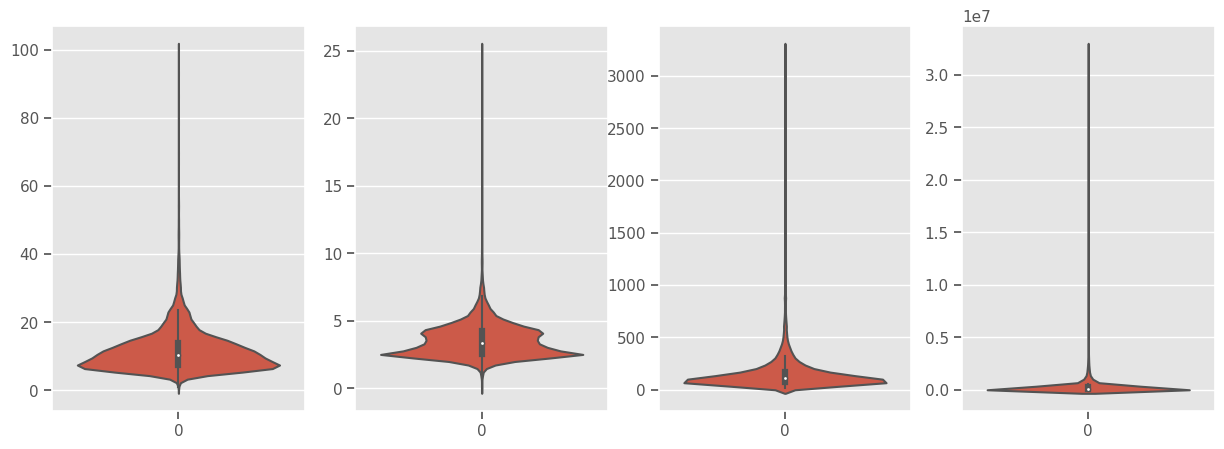

In [60]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.violinplot(df_clean['Length'], inner = 'box', ax = axes[0])
sns.violinplot(df_clean['Width'], inner = 'box', ax = axes[1])
sns.violinplot(df_clean['Number of views last 7 days'], inner = 'box', ax = axes[2])
sns.violinplot(df_clean['Price (USD)'], inner = 'box', ax = axes[3])

<AxesSubplot: xlabel='Price (USD)', ylabel='Count'>

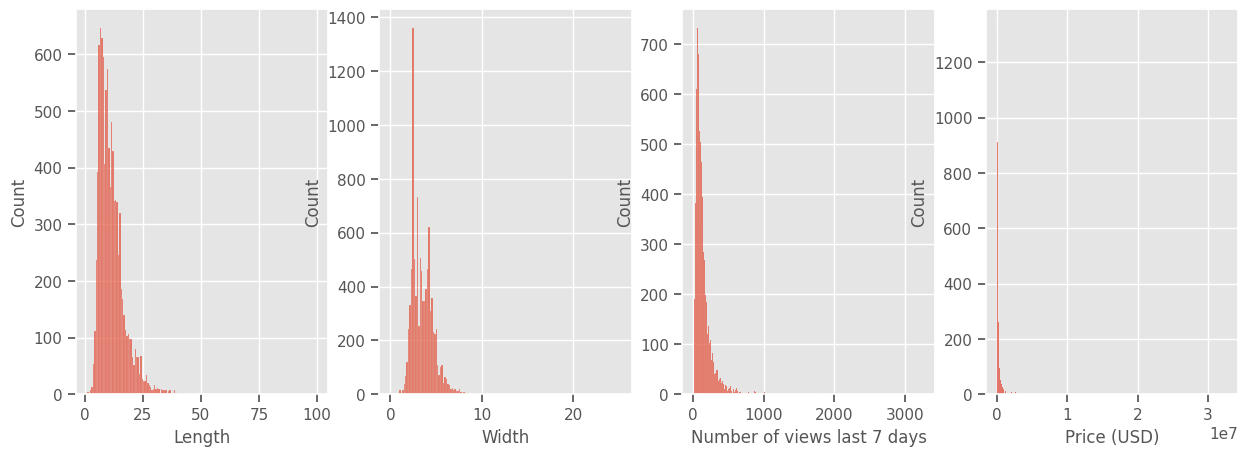

In [61]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.histplot(df_clean['Length'], ax = axes[0])
sns.histplot(df_clean['Width'], ax = axes[1])
sns.histplot(df_clean['Number of views last 7 days'], ax = axes[2])
sns.histplot(df_clean['Price (USD)'], ax = axes[3])

<AxesSubplot: xlabel='Price (USD)', ylabel='Count'>

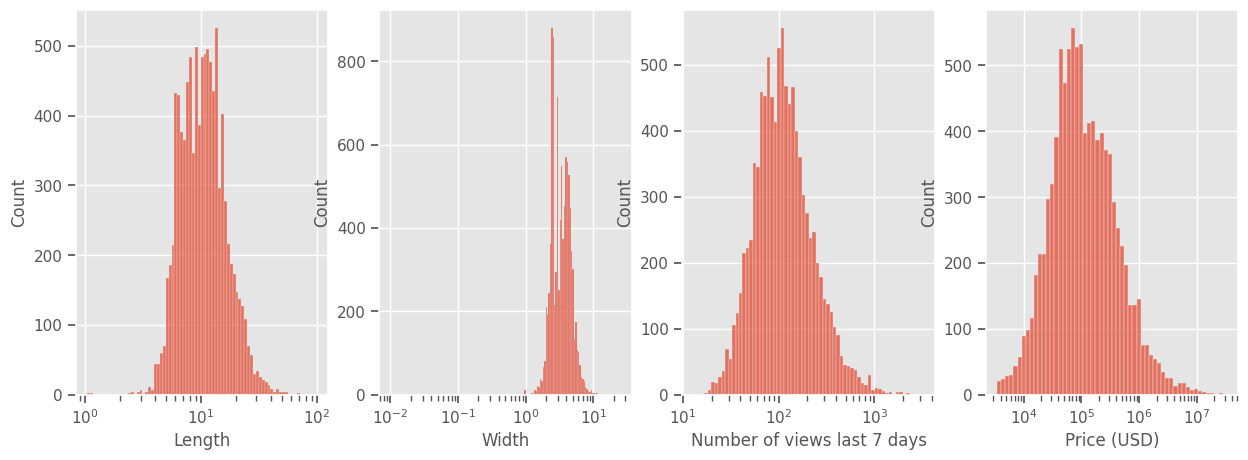

In [62]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.histplot(df_clean['Length'], ax = axes[0], log_scale = True)
sns.histplot(df_clean['Width'], ax = axes[1], log_scale = True)
sns.histplot(df_clean['Number of views last 7 days'], ax = axes[2], log_scale = True)
sns.histplot(df_clean['Price (USD)'], ax = axes[3], log_scale = True)

## Data Imputation

In [63]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 8550 non-null   object 
 2   Year Built                   9337 non-null   float64
 3   Length                       9879 non-null   float64
 4   Width                        9832 non-null   float64
 5   Material                     8139 non-null   object 
 6   Number of views last 7 days  9888 non-null   int64  
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9802 non-null   object 
 13  Fuel              

<AxesSubplot: >

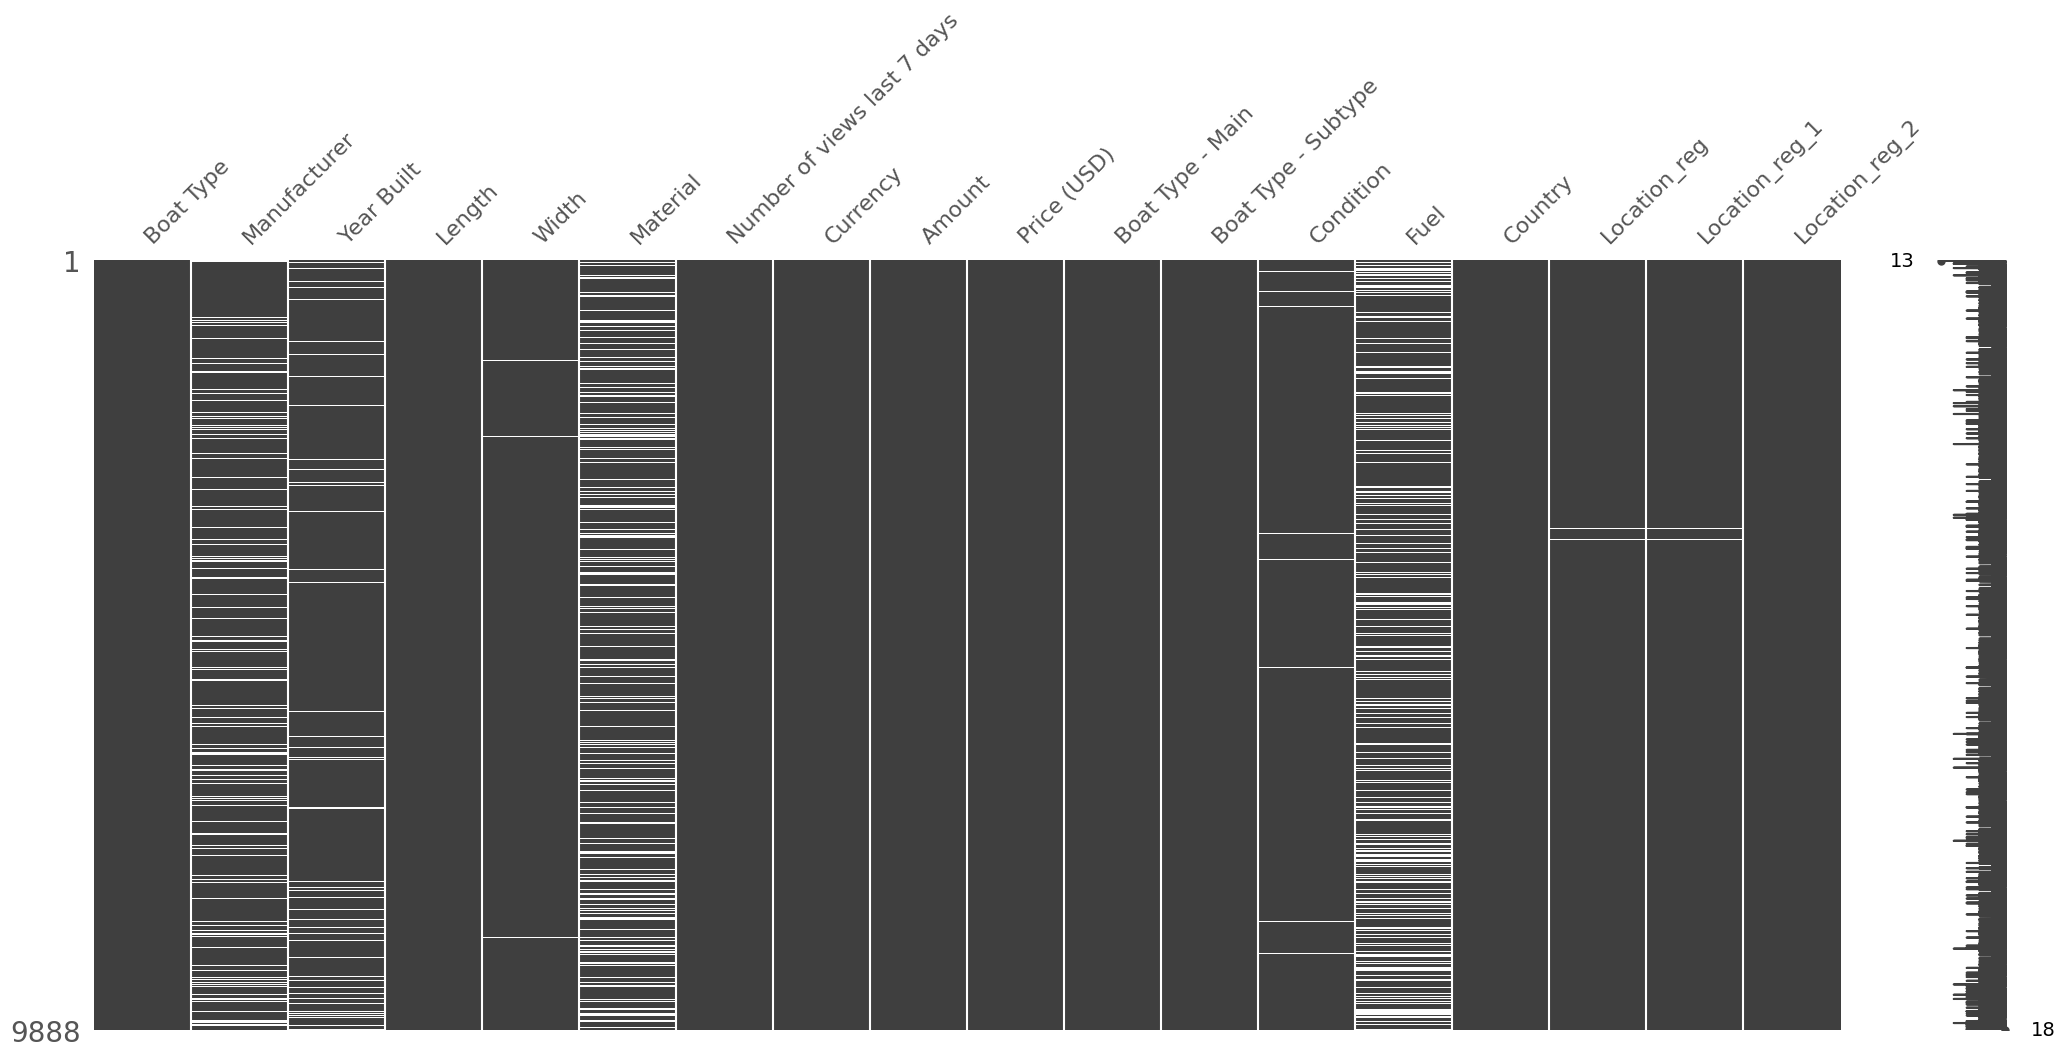

In [64]:
msno.matrix(df_clean)

<AxesSubplot: >

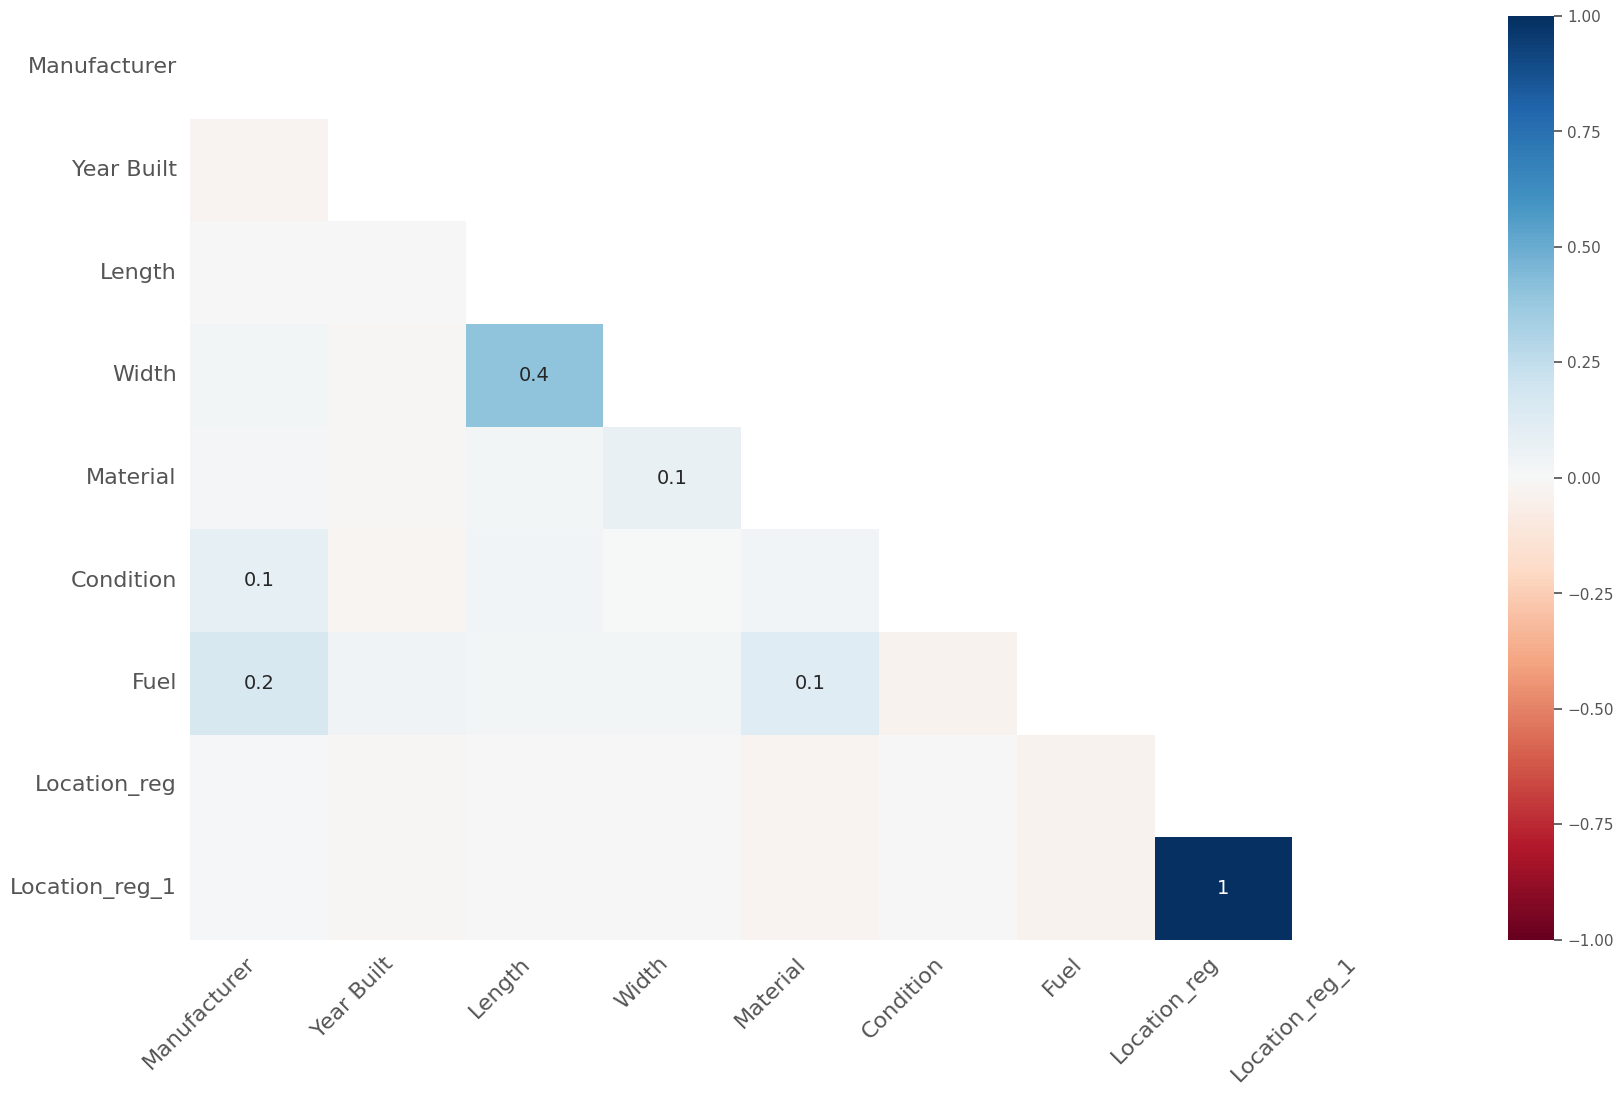

In [65]:
msno.heatmap(df_clean)

<AxesSubplot: >

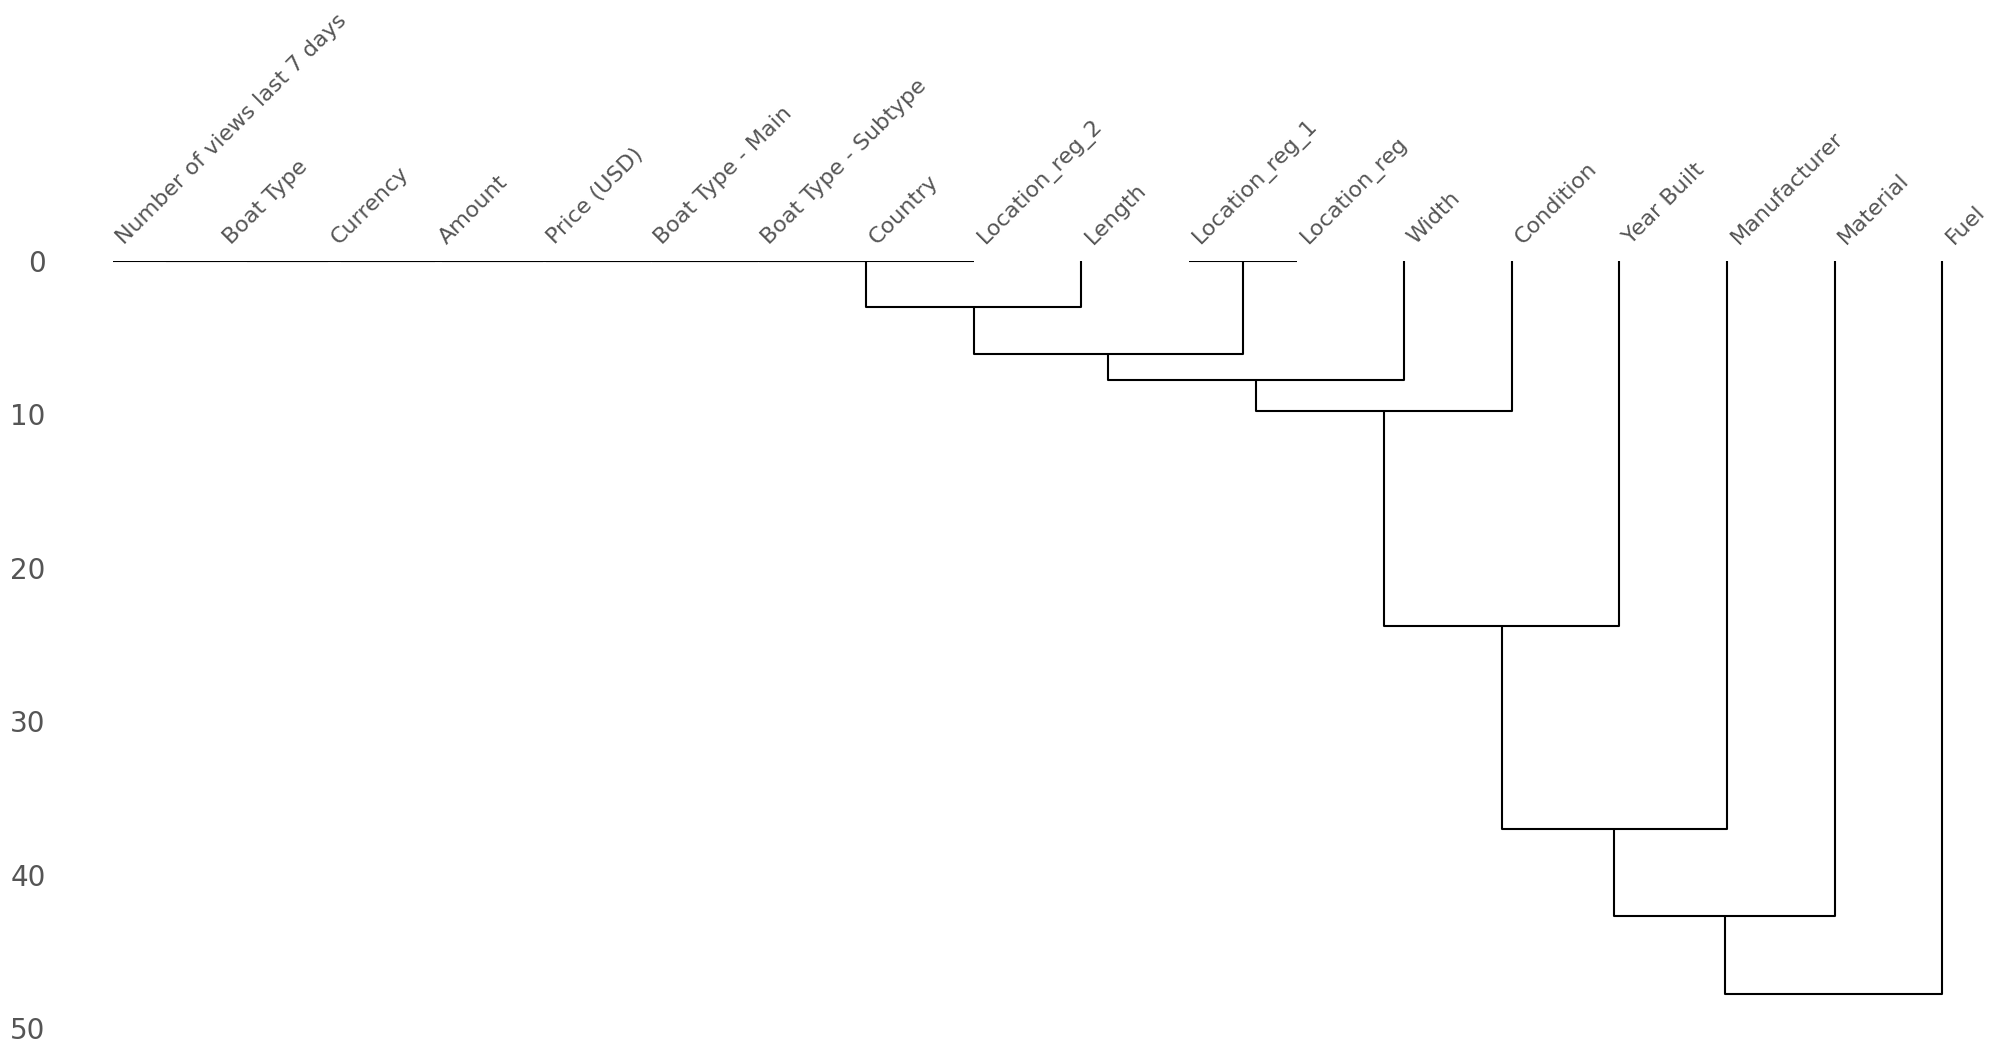

In [66]:
msno.dendrogram(df_clean)

In [67]:
cat_encode = OrdinalEncoder()
cat_cols = ['Boat Type', 'Manufacturer', 'Material', 'Currency', 'Condition', 'Fuel', 'Country' , 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'  ]
df_enc = df_clean.copy()
df_enc[cat_cols] = pd.DataFrame(cat_encode.fit_transform(df_clean[cat_cols]), columns = df_clean[cat_cols].columns)
df_enc.head()

Boat Type  Manufacturer  ...  Location_reg_1  Location_reg_2
0       96.0         335.0  ...           780.0           886.0
1       38.0         459.0  ...           317.0             0.0
2      116.0         285.0  ...           782.0           817.0
3      116.0         352.0  ...          1455.0             0.0
4       73.0         263.0  ...           212.0           566.0

[5 rows x 18 columns]

In [68]:
cat_encode.categories_

[array(['Bowrider', 'Bowrider,Cabin Boat,Deck Boat',
        'Bowrider,Center console boat,Sport Boat', 'Bowrider,Classic',
        'Bowrider,Deck Boat,Water ski', 'Bowrider,Motor Yacht,Sport Boat',
        'Bowrider,Motor Yacht,Wakeboard/Wakesurf',
        'Bowrider,Sport Boat,Wakeboard/Wakesurf',
        'Bowrider,Wakeboard/Wakesurf', 'Cabin Boat', 'Cabin Boat,Classic',
        'Cabin Boat,Classic,Flybridge', 'Cabin Boat,Classic,Motor Yacht',
        'Cabin Boat,Classic,Passenger boat', 'Cabin Boat,Classic,Trawler',
        'Cabin Boat,Fishing Boat', 'Cabin Boat,Fishing Boat,House Boat',
        'Cabin Boat,Fishing Boat,Pilothouse',
        'Cabin Boat,Fishing Boat,Sport Boat', 'Cabin Boat,Flybridge',
        'Cabin Boat,Flybridge,Motor Yacht', 'Cabin Boat,Hardtop',
        'Cabin Boat,Hardtop,Motor Yacht', 'Cabin Boat,Hardtop,Sport Boat',
        'Cabin Boat,Hardtop,Trawler', 'Cabin Boat,House Boat',
        'Cabin Boat,House Boat,Trawler', 'Cabin Boat,Motor Yacht',
        'Cabin B

In [69]:
imp = IterativeImputer(estimator = RandomForestRegressor(), missing_values= np.nan, max_iter=30, random_state=0)
imp.fit(df_enc)

IterativeImputer(estimator=RandomForestRegressor(), max_iter=30, random_state=0)

In [70]:
df_imp = pd.DataFrame(imp.transform(df_enc), columns = df_enc.columns )

In [71]:
df_imp.describe()

Boat Type  Manufacturer  ...  Location_reg_1  Location_reg_2
count  9888.000000   9888.000000  ...     9888.000000     9888.000000
mean     86.348706    253.296208  ...      710.148507      185.761731
std      32.334545    135.702183  ...      521.608333      288.639505
min       0.000000      0.000000  ...        0.000000        0.000000
25%      80.000000    125.000000  ...      230.750000        0.000000
50%      96.000000    252.030000  ...      750.000000        0.000000
75%     109.000000    369.000000  ...     1026.000000      347.250000
max     125.000000    513.000000  ...     1767.000000     1008.000000

[8 rows x 18 columns]

In [72]:
df_enc.describe()

Boat Type  Manufacturer  ...  Location_reg_1  Location_reg_2
count  9888.000000   8550.000000  ...     9852.000000     9888.000000
mean     86.348706    251.207836  ...      710.145351      185.761731
std      32.334545    143.940737  ...      522.560557      288.639505
min       0.000000      0.000000  ...        0.000000        0.000000
25%      80.000000    108.000000  ...      222.750000        0.000000
50%      96.000000    245.000000  ...      753.000000        0.000000
75%     109.000000    371.000000  ...     1030.250000      347.250000
max     125.000000    513.000000  ...     1767.000000     1008.000000

[8 rows x 18 columns]

In [73]:
df_clean_impd = df_imp.copy()
df_clean_impd[cat_cols] = pd.DataFrame(cat_encode.inverse_transform(df_clean_impd[cat_cols]), columns = cat_cols)
df_clean_impd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Boat Type                    9888 non-null   object 
 1   Manufacturer                 9888 non-null   object 
 2   Year Built                   9888 non-null   float64
 3   Length                       9888 non-null   float64
 4   Width                        9888 non-null   float64
 5   Material                     9888 non-null   object 
 6   Number of views last 7 days  9888 non-null   float64
 7   Currency                     9888 non-null   object 
 8   Amount                       9888 non-null   float64
 9   Price (USD)                  9888 non-null   float64
 10  Boat Type - Main             9888 non-null   object 
 11  Boat Type - Subtype          9888 non-null   object 
 12  Condition                    9888 non-null   object 
 13  Fuel              

In [74]:
[df_clean_impd['Country'].nunique(), df_clean['Country'].nunique()]

[126, 126]

In [75]:
# Winsorize Outliers 
outlier_columns = ['Length', 'Width', 'Number of views last 7 days', 'Price (USD)']
limits = [[0.002, 0.001], [0.004, 0.005], [0.0001, 0.001], [0.00001, 0.001]]
df_clean_impd_wind = df_clean_impd.copy()

for i in range(4):
    current_col = outlier_columns[i]
    current_lim = limits[i] 
    df_clean_impd_wind[current_col] = pd.DataFrame(stats.mstats.winsorize(df_clean_impd_wind[current_col], limits = current_lim))

df_clean_impd_wind.describe()

Year Built       Length  ...        Amount   Price (USD)
count  9888.000000  9888.000000  ...  9.888000e+03  9.888000e+03
mean   2005.480445    11.552148  ...  3.201373e+05  3.138662e+05
std      16.294937     5.819638  ...  1.007482e+06  9.168856e+05
min    1885.000000     3.000000  ...  3.300000e+03  3.479850e+03
25%    2000.000000     7.470000  ...  4.400000e+04  4.534350e+04
50%    2008.000000    10.280000  ...  9.500000e+04  9.761717e+04
75%    2018.000000    13.920000  ...  2.550000e+05  2.622615e+05
max    2021.000000    53.500000  ...  3.100000e+07  1.565932e+07

[8 rows x 6 columns]

In [76]:
df_clean_impd_wind.drop(['Amount', 'Currency'], axis = 1, inplace = True)
df_clean_impd_wind.rename(columns = {'Number of views last 7 days' : 'Views (last 7 days)', 'Year Built': 'Year'}, inplace=True)

<AxesSubplot: xlabel='Price (USD)', ylabel='Count'>

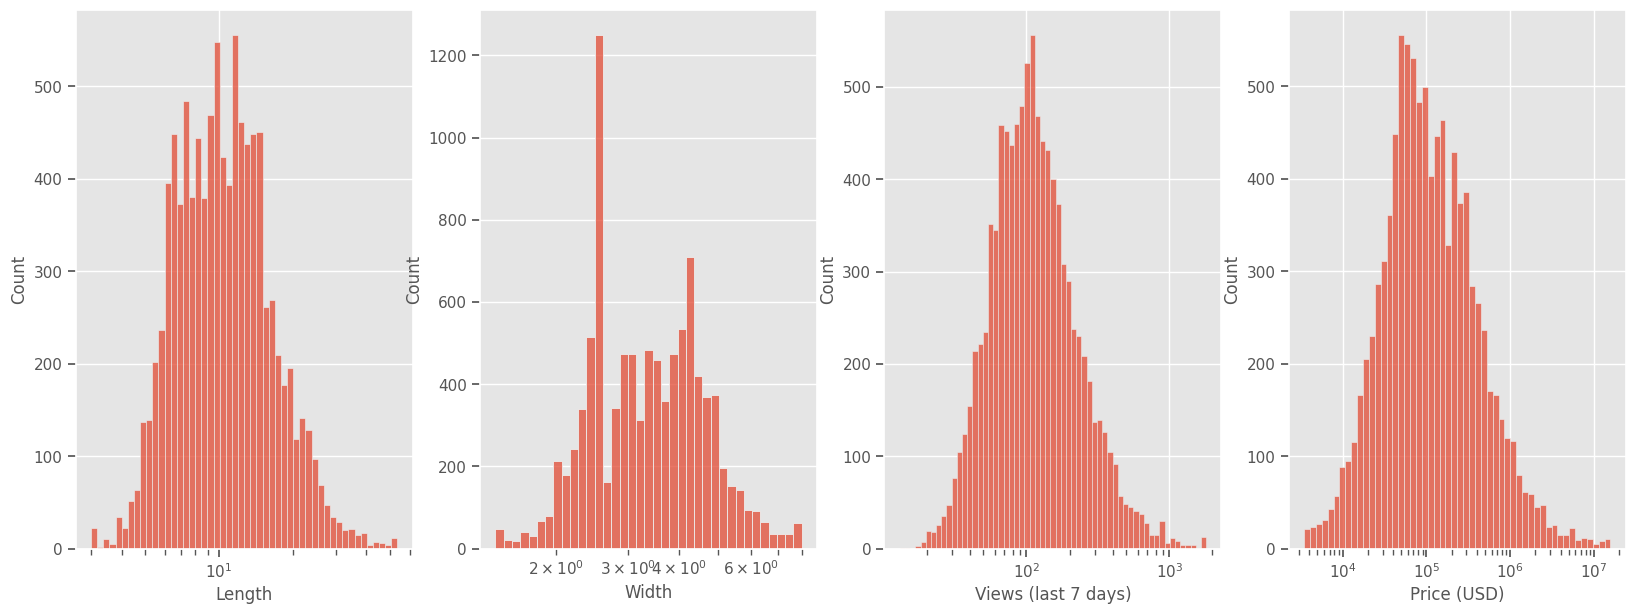

In [77]:
fig, axes = plt.subplots(1,4,figsize=(20,7))
sns.histplot(df_clean_impd_wind['Length'], ax = axes[0], log_scale = True)
sns.histplot(df_clean_impd_wind['Width'], ax = axes[1], log_scale = True)
sns.histplot(df_clean_impd_wind['Views (last 7 days)'], ax = axes[2], log_scale = True)
sns.histplot(df_clean_impd_wind['Price (USD)'], ax = axes[3], log_scale = True)

<AxesSubplot: >

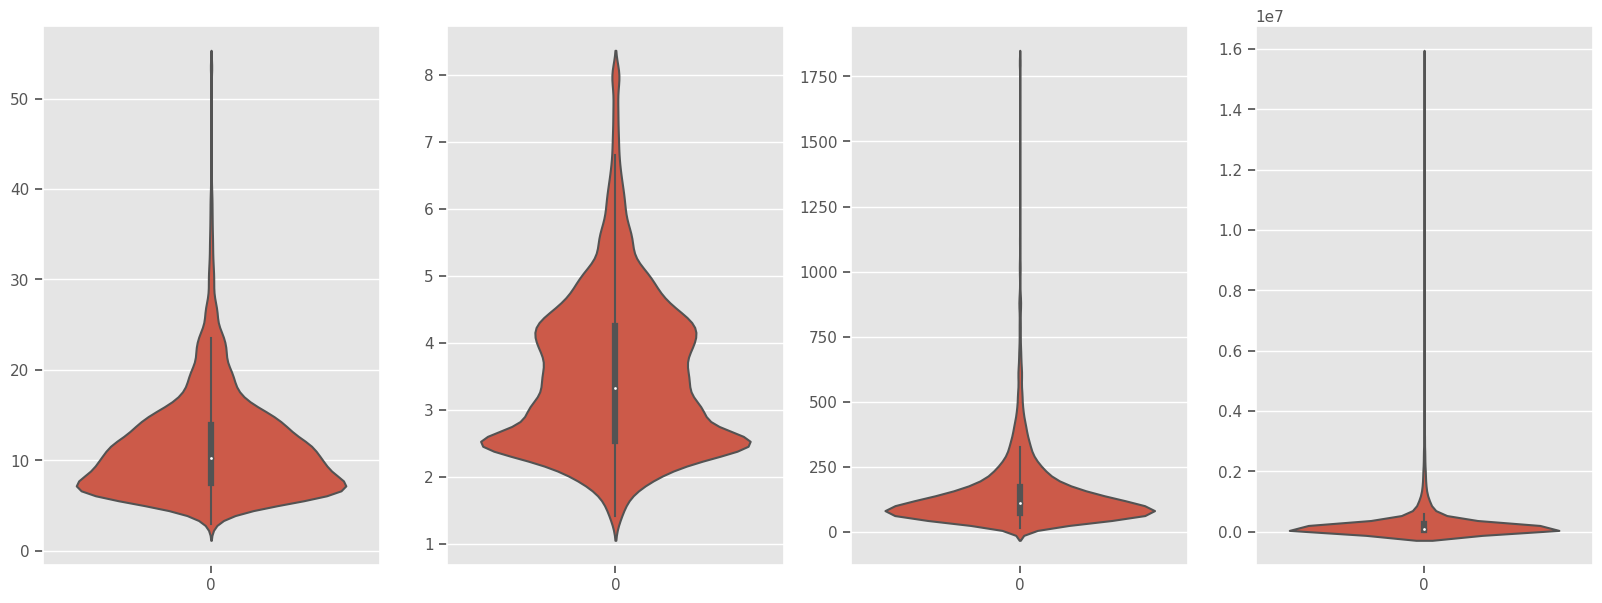

In [78]:
fig, axes = plt.subplots(1,4,figsize=(20,7))
sns.violinplot(df_clean_impd_wind['Length'], inner = 'box', ax = axes[0])
sns.violinplot(df_clean_impd_wind['Width'], inner = 'box', ax = axes[1])
sns.violinplot(df_clean_impd_wind['Views (last 7 days)'], inner = 'box', ax = axes[2])
sns.violinplot(df_clean_impd_wind['Price (USD)'], inner = 'box', ax = axes[3])

In [79]:
df_clean_impd_wind['Log(Views_7d)'] = np.log10(df_clean_impd_wind['Views (last 7 days)'])
df_clean_impd_wind['Log(Length)'] = np.log10(df_clean_impd_wind['Length'])
df_clean_impd_wind['Log(Width)'] = np.log10(df_clean_impd_wind['Width'])
df_clean_impd_wind['Log(Price)'] = np.log10(df_clean_impd_wind['Price (USD)'])

Note - Perfrom Box Cogg transformation to reduce these distributions to a normal one

# Exploratory Data Analysis

### Target Variable - Views (7 days)

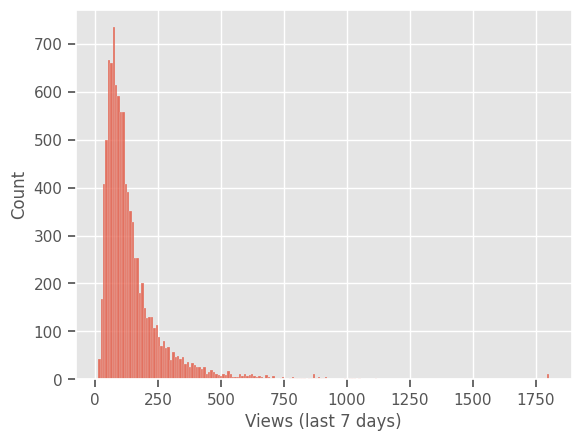

In [80]:
sns.histplot(df_clean_impd_wind['Views (last 7 days)'])
plt.show()

[Text(0.5, 1.0, 'The Correlation Heatmap between Numeric Variables')]

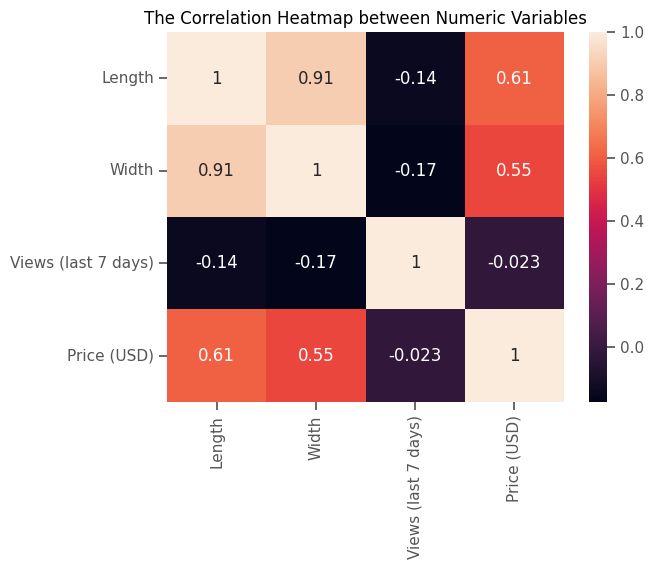

In [81]:
num_columns = ['Length', 'Width', 'Views (last 7 days)', 'Price (USD)']
num_cols = df_clean_impd_wind[num_columns]
sns.heatmap(num_cols.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables')

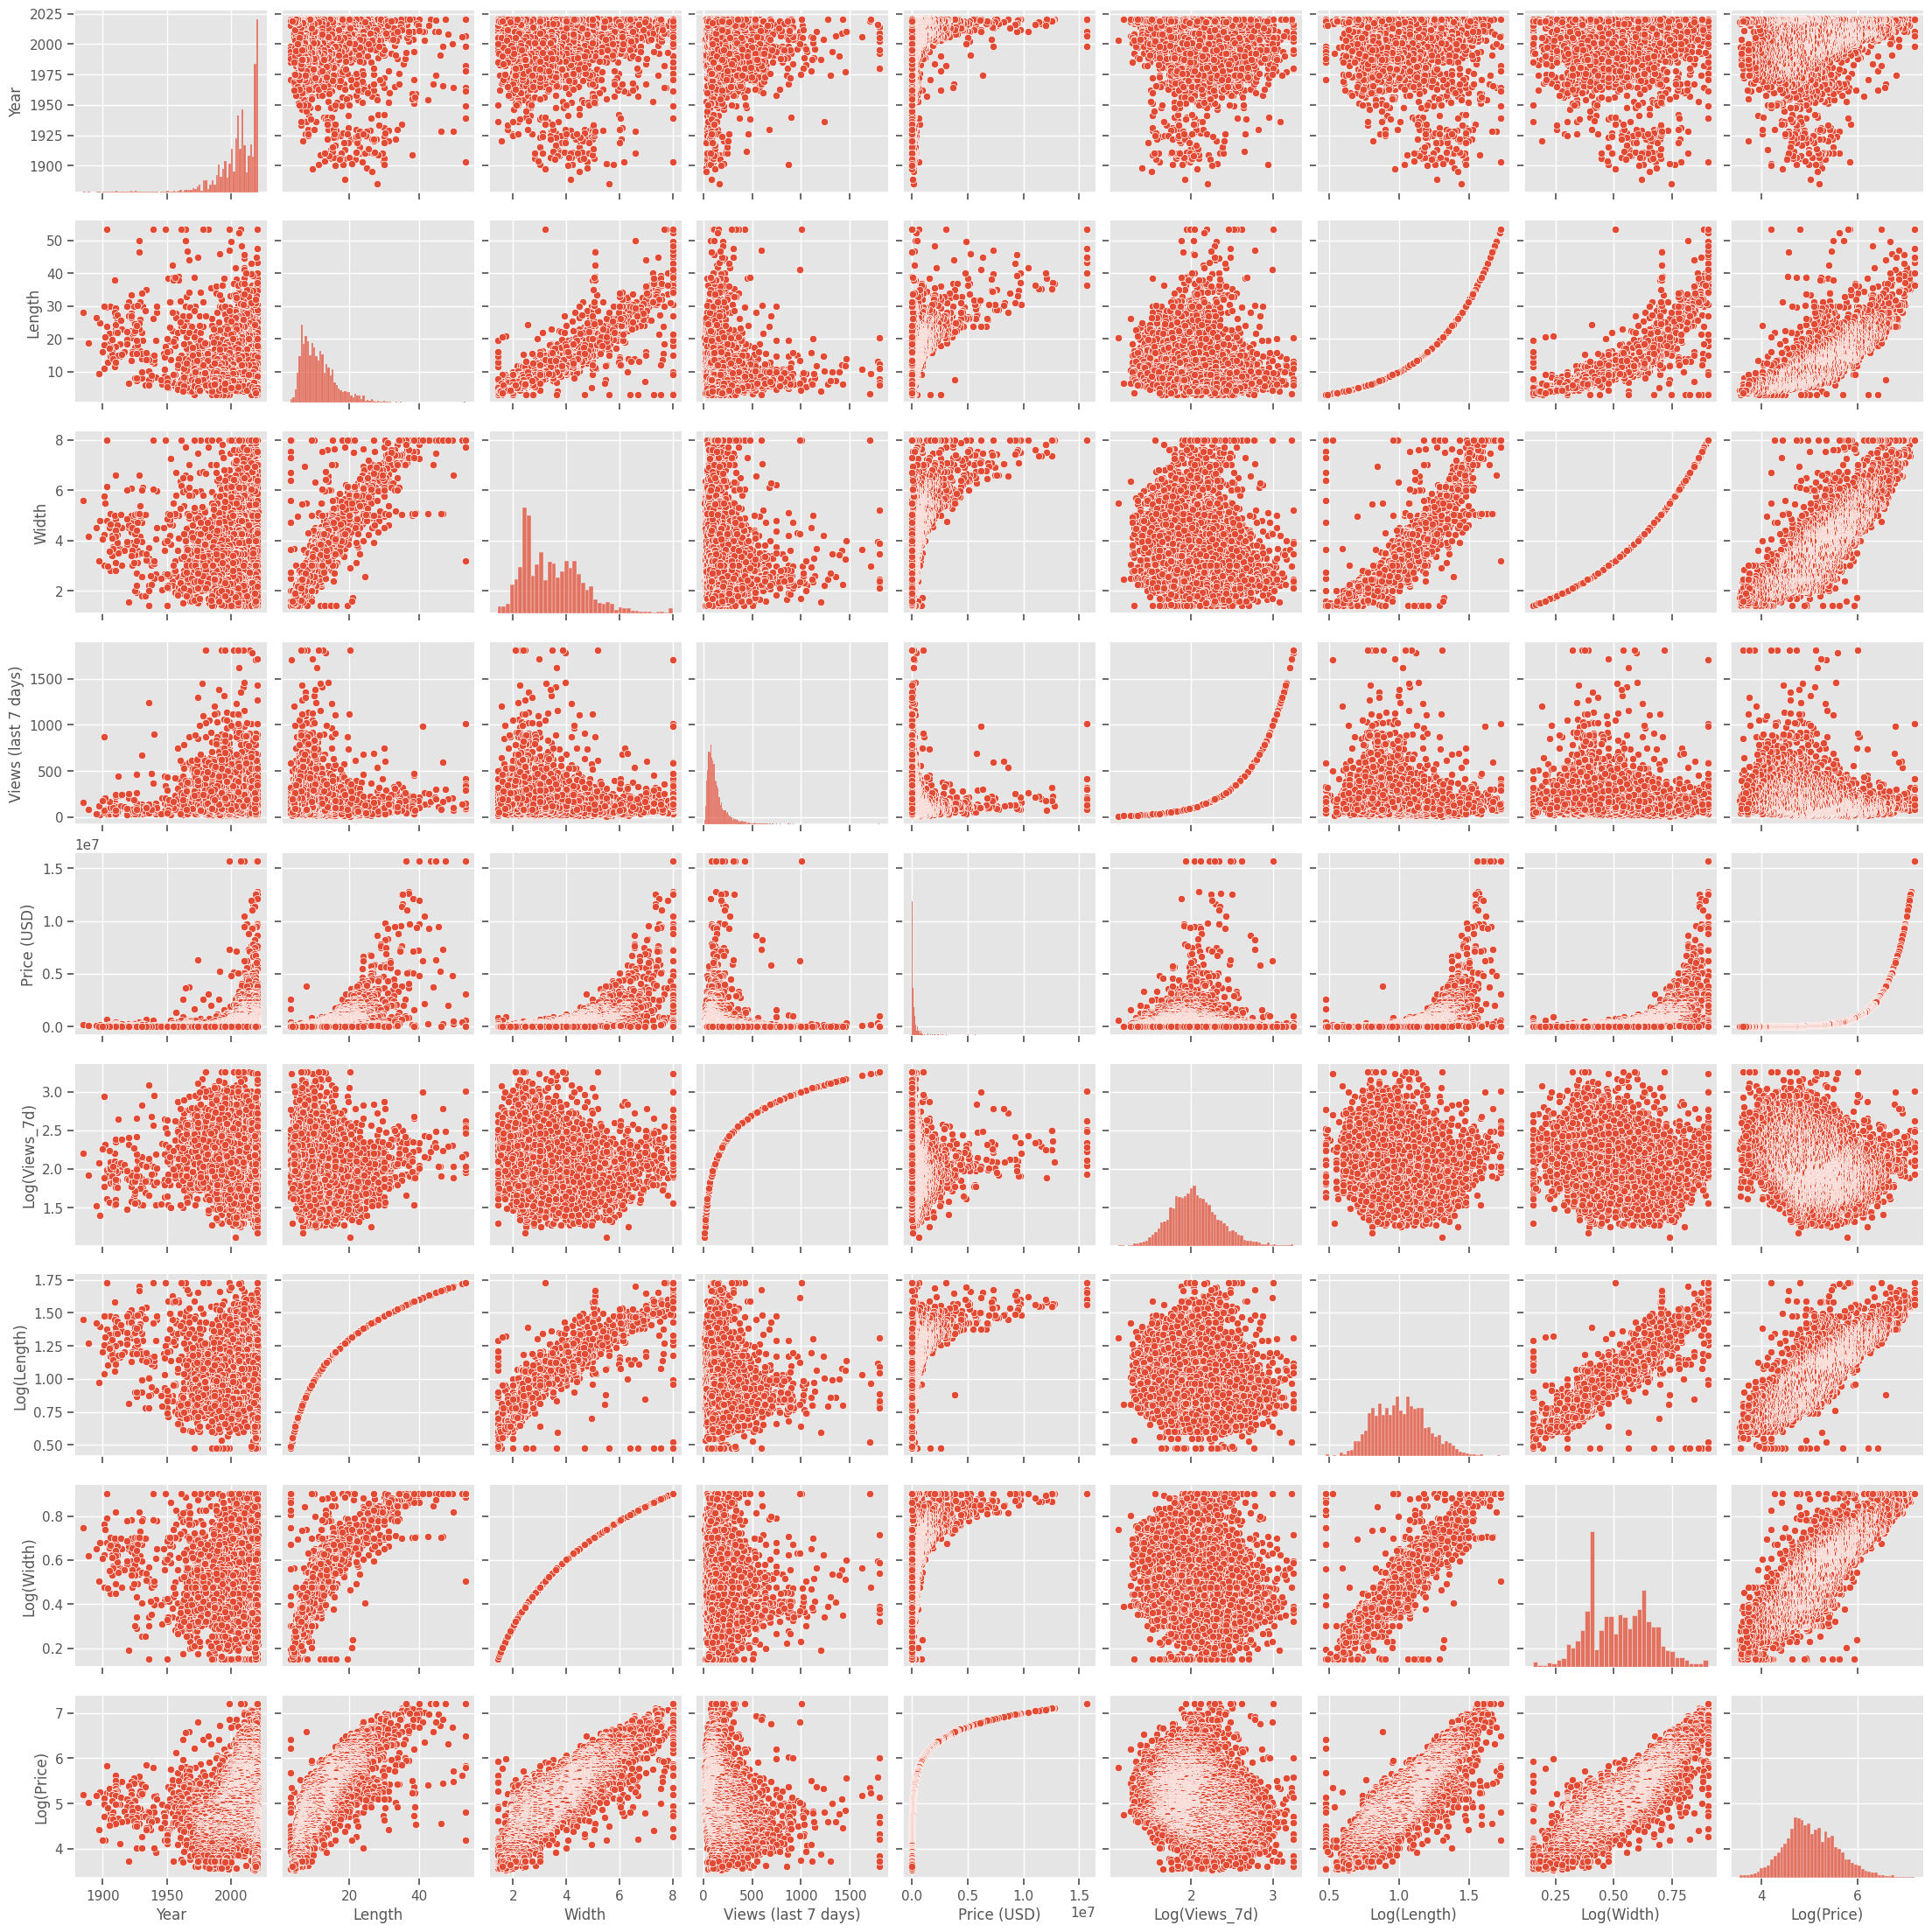

In [82]:
sns.pairplot(df_clean_impd_wind)
plt.show()

<AxesSubplot: xlabel='Price (USD)', ylabel='Log(Views_7d)'>

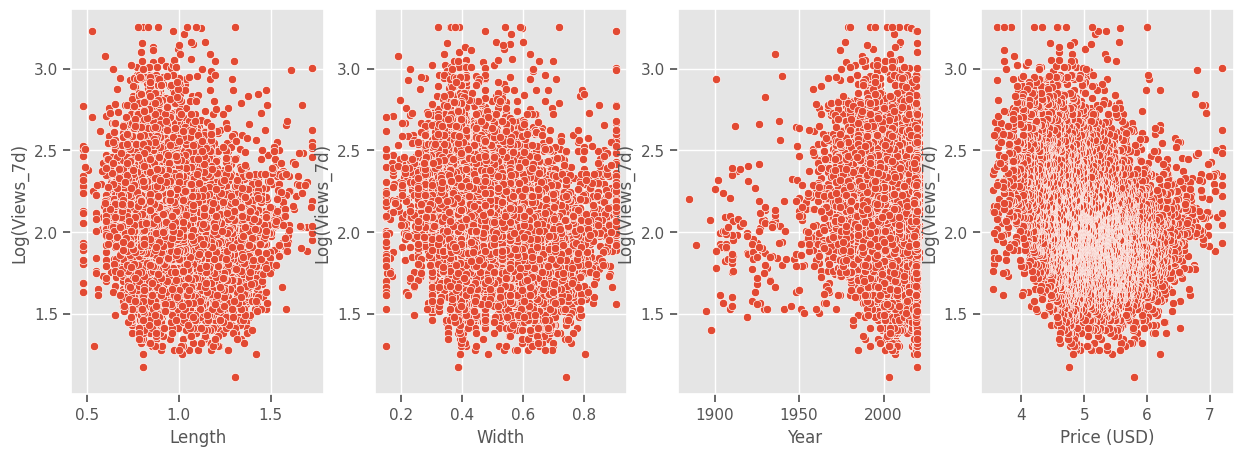

In [83]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Length']), ax=axes[0])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Width']), ax=axes[1])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = df_clean_impd_wind['Year'], ax=axes[2])
sns.scatterplot(y = df_clean_impd_wind['Log(Views_7d)'], x = np.log10(df_clean_impd_wind['Price (USD)']), ax=axes[3])

This might be a problem for the model as there seems to be no notable dependency on the numeric variables

<AxesSubplot: xlabel='Year', ylabel='Log(Price)'>

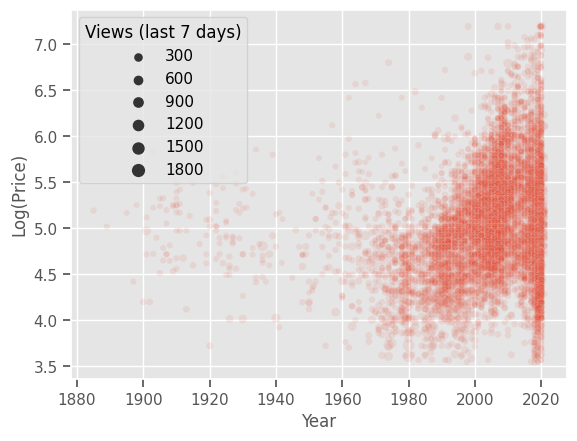

In [84]:
sns.scatterplot( data = df_clean_impd_wind, x = 'Year', y = 'Log(Price)', size = 'Views (last 7 days)', alpha = 0.1)

# Model Fitting and Evaluation

### Prepare Data for Modeling
- Normalize features
- Convert categorical values into numeric features
- Split data into training and test set


In [85]:
df_clean_impd_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Boat Type            9888 non-null   object 
 1   Manufacturer         9888 non-null   object 
 2   Year                 9888 non-null   float64
 3   Length               9888 non-null   float64
 4   Width                9888 non-null   float64
 5   Material             9888 non-null   object 
 6   Views (last 7 days)  9888 non-null   float64
 7   Price (USD)          9888 non-null   float64
 8   Boat Type - Main     9888 non-null   object 
 9   Boat Type - Subtype  9888 non-null   object 
 10  Condition            9888 non-null   object 
 11  Fuel                 9888 non-null   object 
 12  Country              9888 non-null   object 
 13  Location_reg         9888 non-null   object 
 14  Location_reg_1       9888 non-null   object 
 15  Location_reg_2       9888 non-null   o

In [86]:
df_model = df_clean_impd_wind.copy()
cat_encode = OrdinalEncoder()
cat_cols = ['Boat Type', 'Manufacturer', 'Material', 'Condition', 'Fuel', 'Country', 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'   ]


df_model[cat_cols] = cat_encode.fit_transform(df_model[cat_cols]) 

In [87]:
df_model.columns

Index(['Boat Type', 'Manufacturer', 'Year', 'Length', 'Width', 'Material',
       'Views (last 7 days)', 'Price (USD)', 'Boat Type - Main',
       'Boat Type - Subtype', 'Condition', 'Fuel', 'Country', 'Location_reg',
       'Location_reg_1', 'Location_reg_2', 'Log(Views_7d)', 'Log(Length)',
       'Log(Width)', 'Log(Price)'],
      dtype='object')

In [88]:
feature_cols = ['Boat Type', 'Manufacturer', 'Year', 'Material', 'Condition', 'Fuel', 'Country', 'Log(Length)', 'Log(Width)', 'Log(Price)', 'Boat Type - Main', 'Boat Type - Subtype',  'Location_reg', 'Location_reg_1', 'Location_reg_2'  ]
X = df_model[feature_cols]           # Features
y = df_model['Log(Views_7d)']  # Target variable

In [89]:
# define the scaler 
scaler = PowerTransformer()
# fit and transform the train set
#X[['Year','Length', 'Width', 'Price (USD)', 'Log(Length)', 'Log(Width)', 'Log(Price)']] = scaler.fit_transform(X[['Year','Length', 'Width', 'Price (USD)', 'Log(Length)', 'Log(Width)', 'Log(Price)']])
X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']] = scaler.fit_transform(X[['Year', 'Log(Length)', 'Log(Width)', 'Log(Price)']])

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Linear Regression Model

In [91]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [92]:
y_pred = lr.predict(X_test)
print('Linear Regression r2_score: ',r2_score(y_test,y_pred))
print('Linear Regression Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Linear Regression r2_score:  0.2307793956126435
Linear Regression Root Mean Squared Error:  0.2741975755069809


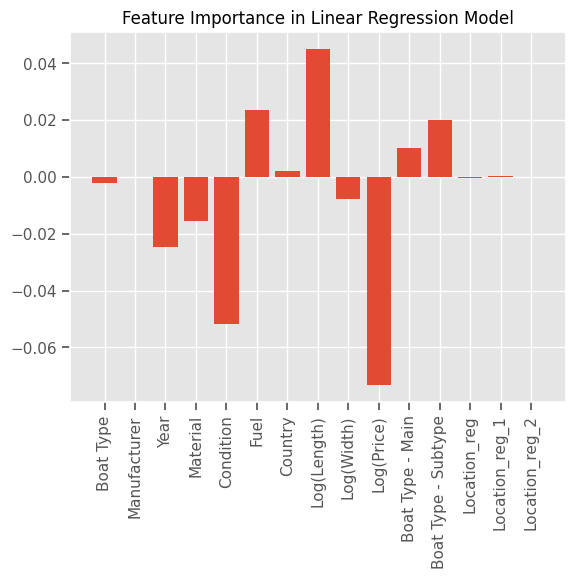

In [93]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model');

### Decision Tree Regression Model

In [94]:
tree = DecisionTreeRegressor(max_depth=12,min_samples_split=2,random_state=42)
tree.fit(X_train,y_train)
y_pred2 = tree.predict(X_test)

In [95]:
d_r2 = tree.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Decision Tree Regressor R-squared: 0.31401526484492803
Decision Tree Regressor RMSE: 0.25893775709511324


### Random Forest Regresison Model

In [96]:
forest = RandomForestRegressor() #max_depth=50,min_samples_split=2,random_state=42
forest.fit(X_train,y_train)
y_pred2 = forest.predict(X_test)

In [97]:
d_r2 = forest.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Decision Tree Regressor R-squared: 0.4854489991246326
Decision Tree Regressor RMSE: 0.22426028495478478


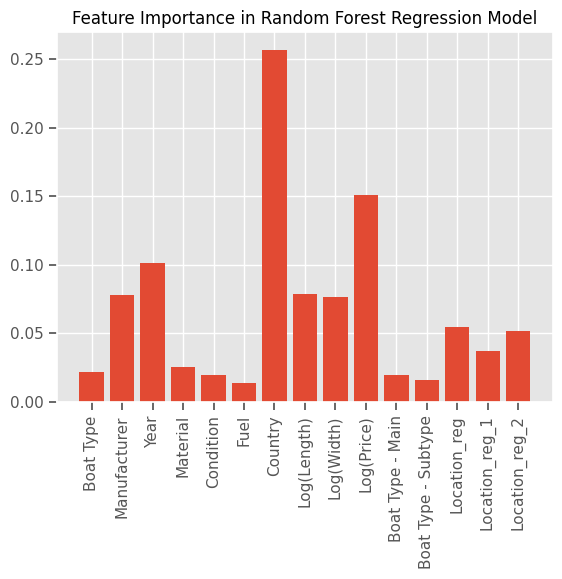

In [98]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = forest.feature_importances_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Regression Model');

### Finding the best parameter for Decision Tree Regression Model

Best max_depth is: 17 
Testing R^2 is: 0.4885191139436905


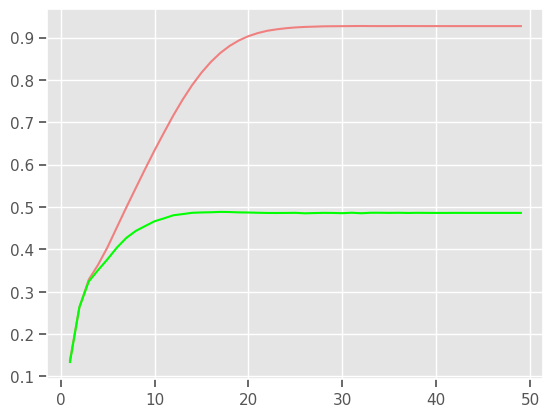

In [99]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    tree = RandomForestRegressor(max_depth=i,random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    train_score.append(tree.score(X_train,y_train))
    test_score.append(r2_score(y_test,y_pred))
    test_pair = (i,r2_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training R^2",color='lightcoral')
ax.plot(np.arange(1,50), test_score, label = "Testing R^2",color='lime')
print(f'Best max_depth is: {max_pair[0]} \nTesting R^2 is: {max_pair[1]}')

### Gradient Boosting Regression Model

In [100]:
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.predict(X_test[1:2])
reg.score(X_test, y_test)

0.45671507250296006

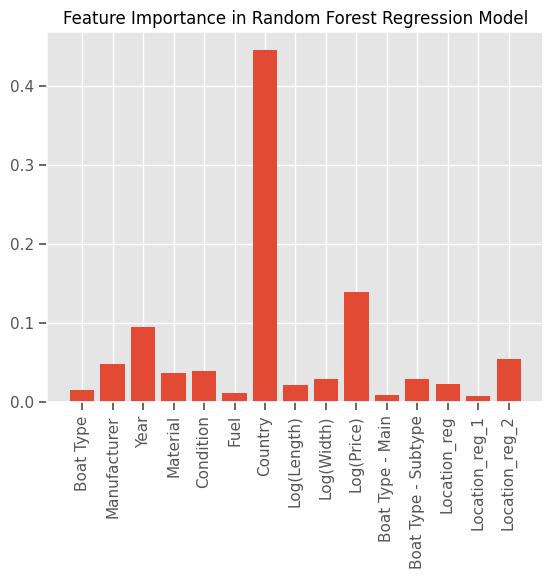

In [101]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = reg.feature_importances_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Regression Model');